## Running example from the readme


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def generate_gp_samples_with_library(n_groups, n_observations_per_group, n_dimensions, time_points, length_scale=1.0):
    """
    Generate multidimensional GP samples using scikit-learn.
    Each dimension has the same underlying process.
    """
    kernel = RBF(length_scale=length_scale)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-8)

    gp_sample_constant = gp.sample_y(time_points.reshape(-1, 1), random_state=None).flatten()

    samples = []
    for _ in range(n_groups):
        group_samples = []
        for _ in range(n_observations_per_group):
            # Generate independent samples for each dimension
            gp_samples_per_dim = []
            for _ in range(n_dimensions):
                gp_sample = gp.sample_y(time_points.reshape(-1, 1), random_state=None).flatten()
                gp_samples_per_dim.append(gp_sample)
            # Stack the samples to form a multidimensional sample
            gp_samples_multidim = np.stack(gp_samples_per_dim, axis=-1)
            group_samples.append(gp_samples_multidim)
        samples.append(np.array(group_samples))

    return samples

# Parameters
n_groups = 1
n_observations_per_group = 5000
n_dimensions = 3
n_time_points = 50
time_points = np.linspace(0, 10, n_time_points)
length_scale = 1.5

# Generate GP samples
gp_samples = generate_gp_samples_with_library(
    n_groups=n_groups,
    n_observations_per_group=n_observations_per_group,
    n_dimensions=n_dimensions,
    time_points=time_points,
    length_scale=length_scale
)

if False:
    # Plot example
    for dim in range(n_dimensions):
        for group_idx in range(n_groups):
            plt.figure()
            for observation in gp_samples[group_idx]:
                plt.plot(time_points, observation[:, dim], label=f"Dim {dim + 1}")
            plt.title(f"Group {group_idx + 1} Observations for Dimension {dim + 1}")
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.show()


In [25]:
n_new_dims = 10
Proj = np.random.uniform(size = (n_dimensions, n_new_dims))#.reshape(1,1,n_dimensions, n_new_dims)
X = gp_samples[0] @ Proj

In [26]:
from pygrinder import mcar
X = mcar(X, 0.01)  # randomly hold out 10% observed values as ground truth
X[X!=X] = 0
dataset = {'X' : X[:]}


In [61]:

# Model training. This is PyPOTS showtime.
from pypots.imputation import GP_VAE
from pypots.utils.metrics import calc_mae
from pypots.optim.adam import Adam
from torch.optim.lr_scheduler import LRScheduler

gpvae = GP_VAE(n_steps = dataset['X'].shape[1], 
            n_features = dataset['X'].shape[2], 
            latent_size = 3, 
            epochs = 15, 
            batch_size = 8,
            beta = .01, 
            K = 10,  
            encoder_sizes = (128,), 
            decoder_sizes = (128,),
            optimizer = Adam(lr = 1e-4) #, v
            )

gpvae.model.backbone.p = 0.05
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
gpvae.fit(dataset)  # train the model on the dataset

2024-11-21 15:54:11 [INFO]: No given device, using default device: cpu
2024-11-21 15:54:11 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2024-11-21 15:54:11 [INFO]: GP_VAE initialized with the given hyperparameters, the number of trainable parameters: 5,270


Model dimensions is: 
GpvaeEncoder(
  (net): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
  )
  (mu_layer): Linear(in_features=128, out_features=3, bias=True)
  (logvar_layer): Linear(in_features=128, out_features=3, bias=True)
)
GpvaeDecoder(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


2024-11-21 15:54:41 [INFO]: Epoch 001 - training loss: 0.9559
2024-11-21 15:55:13 [INFO]: Epoch 002 - training loss: 0.2767
2024-11-21 15:55:47 [INFO]: Epoch 003 - training loss: 0.1930
2024-11-21 15:56:32 [INFO]: Epoch 004 - training loss: 0.1528
2024-11-21 15:57:06 [INFO]: Epoch 005 - training loss: 0.1061
2024-11-21 15:57:37 [INFO]: Epoch 006 - training loss: 0.0864
2024-11-21 15:58:10 [INFO]: Epoch 007 - training loss: 0.0734
2024-11-21 15:58:43 [INFO]: Epoch 008 - training loss: 0.0642
2024-11-21 15:59:15 [INFO]: Epoch 009 - training loss: 0.0570
2024-11-21 15:59:48 [INFO]: Epoch 010 - training loss: 0.0516
2024-11-21 16:00:21 [INFO]: Epoch 011 - training loss: 0.0472
2024-11-21 16:00:50 [INFO]: Epoch 012 - training loss: 0.0439
2024-11-21 16:01:24 [INFO]: Epoch 013 - training loss: 0.0413
2024-11-21 16:01:55 [INFO]: Epoch 014 - training loss: 0.0390
2024-11-21 16:02:23 [INFO]: Epoch 015 - training loss: 0.0375
2024-11-21 16:02:23 [INFO]: Finished training. The best model is from 

In [62]:
# Assume 'model' is your neural network instance
torch.save(gpvae.model.backbone.state_dict(), 'model_weights.pth')

#gpvae_backup = gpvae

2024-11-21 16:03:04 [INFO]: Epoch 001 - training loss: 0.0671
2024-11-21 16:03:33 [INFO]: Epoch 002 - training loss: 0.0653
2024-11-21 16:04:04 [INFO]: Epoch 003 - training loss: 0.0642
2024-11-21 16:04:35 [INFO]: Epoch 004 - training loss: 0.0631
2024-11-21 16:05:07 [INFO]: Epoch 005 - training loss: 0.0621
2024-11-21 16:05:37 [INFO]: Epoch 006 - training loss: 0.0614
2024-11-21 16:06:09 [INFO]: Epoch 007 - training loss: 0.0608
2024-11-21 16:06:39 [INFO]: Epoch 008 - training loss: 0.0602
2024-11-21 16:07:09 [INFO]: Epoch 009 - training loss: 0.0598
2024-11-21 16:07:42 [INFO]: Epoch 010 - training loss: 0.0592
2024-11-21 16:08:15 [INFO]: Epoch 011 - training loss: 0.0587
2024-11-21 16:08:23 [WARNING]: ‼️ Training got interrupted by the user. Exist now ...
2024-11-21 16:08:23 [INFO]: Finished training. The best model is from epoch#11.


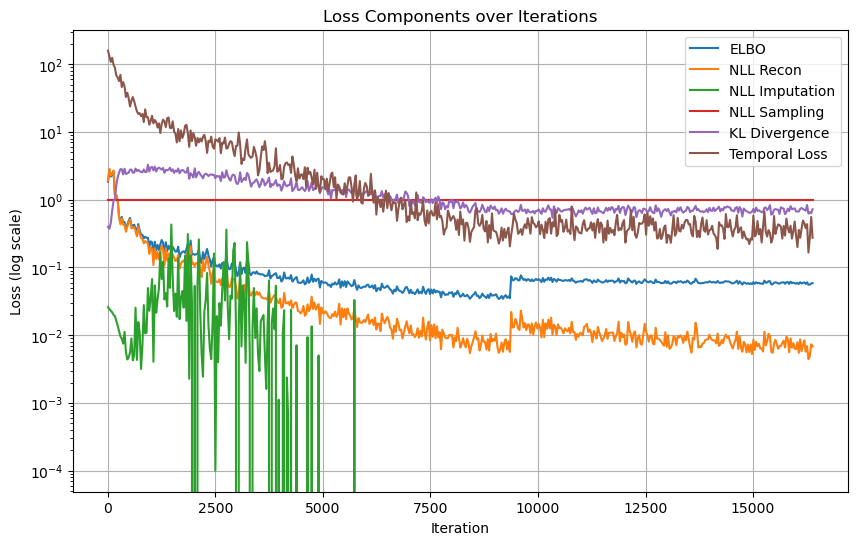

In [63]:
for param in gpvae.model.backbone.decoder.parameters():
    param.requires_grad = False
    
gpvae.model.backbone.p = 0.1
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
gpvae.fit(dataset)  # train the model on the dataset

In [64]:
# Assume 'model' is your neural network instance
torch.save(gpvae.model.backbone.state_dict(), 'model_weights2.pth')

#gpvae_backup = gpvae

In [ ]:
for param in gpvae.model.backbone.decoder.parameters():
    param.requires_grad = False
    
gpvae.model.backbone.p = 0.2
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
gpvae.fit(dataset)  # train the model on the dataset

2024-11-21 16:09:02 [INFO]: Epoch 001 - training loss: 0.1205
2024-11-21 16:09:39 [INFO]: Epoch 002 - training loss: 0.1181
2024-11-21 16:10:11 [INFO]: Epoch 003 - training loss: 0.1170
2024-11-21 16:10:44 [INFO]: Epoch 004 - training loss: 0.1159
2024-11-21 16:11:15 [INFO]: Epoch 005 - training loss: 0.1151
2024-11-21 16:11:47 [INFO]: Epoch 006 - training loss: 0.1145
2024-11-21 16:12:17 [INFO]: Epoch 007 - training loss: 0.1141
2024-11-21 16:12:47 [INFO]: Epoch 008 - training loss: 0.1136
2024-11-21 16:13:15 [INFO]: Epoch 009 - training loss: 0.1132


## RUN THIS

2024-11-21 15:41:45 [INFO]: Epoch 001 - training loss: 0.7751
2024-11-21 15:42:25 [INFO]: Epoch 002 - training loss: 0.8797
2024-11-21 15:43:03 [INFO]: Epoch 003 - training loss: 0.8190
2024-11-21 15:43:35 [INFO]: Epoch 004 - training loss: 0.7101
2024-11-21 15:44:09 [INFO]: Epoch 005 - training loss: 0.5959
2024-11-21 15:44:44 [INFO]: Epoch 006 - training loss: 0.4811
2024-11-21 15:45:17 [INFO]: Epoch 007 - training loss: 0.3795
2024-11-21 15:45:54 [INFO]: Epoch 008 - training loss: 0.5260
2024-11-21 15:46:29 [INFO]: Epoch 009 - training loss: 0.6064
2024-11-21 15:47:02 [INFO]: Epoch 010 - training loss: 0.5869
2024-11-21 15:47:35 [INFO]: Epoch 011 - training loss: 0.5335
2024-11-21 15:48:10 [INFO]: Epoch 012 - training loss: 0.4424
2024-11-21 15:48:44 [INFO]: Epoch 013 - training loss: 0.4686
2024-11-21 15:49:14 [WARNING]: ‼️ Training got interrupted by the user. Exist now ...
2024-11-21 15:49:14 [INFO]: Finished training. The best model is from epoch#7.


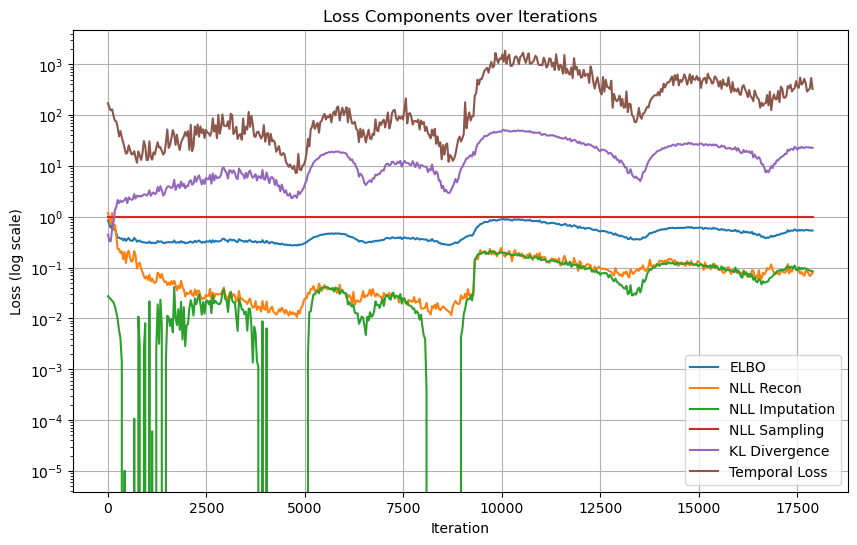

In [58]:
gpvae.model.backbone.p = 0.1

gpvae.fit(dataset)  # train the model on the dataset

In [41]:
## Assess reconstruction error
import torch

z = gpvae.model.backbone.encoder(torch.tensor(X).float()).mean
X_recon = gpvae.model.backbone.decoder(z).mean

error = (torch.tensor(X).float() - X_recon).pow(2)[X!=0].mean()

print(error)

tensor(0.0005, grad_fn=<MeanBackward0>)


In [42]:
for param in gpvae.model.backbone.decoder.parameters():
    param.requires_grad = False
    
gpvae.model.backbone.p = 0.1
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
gpvae.fit(dataset)  # train the model on the dataset

2024-11-21 15:00:55 [ERROR]: ❌ Exception: None


elbo too big 3.2342073917388916 336763232.0 0.48371049761772156


RuntimeError: Training got interrupted. Model was not trained. Please investigate the error printed above.

In [ ]:
gpvae.model.backbone.p = .5
gpvae.model.backbone.sampling = True
gpvae.fit(dataset)  # train the model on the dataset

In [59]:
import gpytorch
import torch
with gpytorch.settings.cholesky_jitter(1e-4):
    with torch.autograd.set_detect_anomaly(True):
        gpvae.fit_kernel(dataset)  # train the model on the dataset


fitting kernel


/Users/louis/miniforge3/envs/pypots-env/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/louis/miniforge3/envs/pypots-env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Error detected in RBFCovarianceBackward. Traceback of forward call that caused the error:
  File "/Users/louis/miniforge3/envs/pypots-env/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/louis/miniforge3/envs/pypots-env/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/louis/miniforge3/envs/pypots-env/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/louis/miniforge3/envs/pypots-env/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
 

KeyboardInterrupt: 

In [ ]:
gpvae.gp.gp_models[0].covar_module.outputscale


In [ ]:
help(gpvae.gp.gp_models[0].covar_module)


In [ ]:
import torch
x = torch.ones((8,48))
gpvae.gp.gp_models[0](x)

In [ ]:
gpvae.gp._fit_kernel

In [ ]:
imputation = gpvae.impute(dataset)  # impute the originally-missing values and artificially-missing values
indicating_mask = np.isnan(X) ^ np.isnan(X_ori)  # indicating mask for imputation error calculation
mae = calc_mae(imputation, np.nan_to_num(X_ori), indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)
gpvae.save("save_it_here/gpvae_physionet2012.pypots")  # save the model for future use
gpvae.load("save_it_here/gpvae_physionet2012.pypots")  # reload the serialized model file for following imputation or training

In [ ]:

# Model training. This is PyPOTS showtime.
from pypots.imputation import GPVAE
from pypots.utils.metrics import calc_mae
gpvae = GPVAE(n_steps=48, n_features=37, latent_size = 12, epochs=10)
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
gpvae.fit(dataset)  # train the model on the dataset
imputation = gpvae.impute(dataset)  # impute the originally-missing values and artificially-missing values
indicating_mask = np.isnan(X) ^ np.isnan(X_ori)  # indicating mask for imputation error calculation
mae = calc_mae(imputation, np.nan_to_num(X_ori), indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)
gpvae.save("save_it_here/gpvae_physionet2012.pypots")  # save the model for future use
gpvae.load("save_it_here/gpvae_physionet2012.pypots")  # reload the serialized model file for following imputation or training

In [ ]:

# Model training. This is PyPOTS showtime.
from pypots.imputation import SAITS
from pypots.utils.metrics import calc_mae
gpvae = SAITS(n_steps=48, n_features=37, n_layers=2, d_model=256, n_heads=4, d_k=64, d_v=64, d_ffn=128, dropout=0.1, epochs=10)
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
gpvae.fit(dataset)  # train the model on the dataset
imputation = gpvae.impute(dataset)  # impute the originally-missing values and artificially-missing values
indicating_mask = np.isnan(X) ^ np.isnan(X_ori)  # indicating mask for imputation error calculation
mae = calc_mae(imputation, np.nan_to_num(X_ori), indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)
gpvae.save("save_it_here/saits_physionet2012.pypots")  # save the model for future use
gpvae.load("save_it_here/saits_physionet2012.pypots")  # reload the serialized model file for following imputation or training